In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

#https://perswww.kuleuven.be/~u0016541/Talks/Keppens.CarolusMagnus2009.pdf

In [3]:
def initialize_data(filename, angle_cut):

    dphi = 0.01
    phi_up = angle_cut + dphi/2
    phi_down = angle_cut - dphi/2
    R0 = 0.2477 
 
    data = np.loadtxt(filename, dtype=float, skiprows=2, delimiter='\t')

    boolarr = np.logical_and(
                    data[:,1] < phi_up,
                    data[:,1] > phi_down)
    
    pos = np.where(boolarr)[0]
    data = data[pos]
    
    rtor = data[:,0]
    thetator = data[:,2]
    phi = data[:,1]
    R = R0+np.multiply(rtor,np.cos(thetator))
    z = np.multiply(rtor,np.sin(thetator))
    B = data[:,3]
    return np.array([R, z, thetator, rtor, phi, B])

In [5]:
data = np.loadtxt("coordenadasMEDUSA.txt", dtype=float, delimiter='\t')

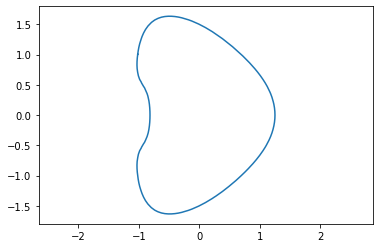

In [6]:
Rmed, Zmed = data.T
R0M = 0.14
am = R0M/1.32

def ciltocart(Rmed, Zmed, R0M, am):
    rmed = Rmed-R0M
    xmed = rmed/am
    ymed = Zmed/am
    thtmed = np.arctan2(Zmed,rmed)
    Rm = np.sqrt(xmed**2+ymed**2)
    
    return np.array([xmed, ymed]), Rm, thtmed

xypoints, Rm, thtmed = ciltocart(Rmed, Zmed, R0M, am)

datos = np.array([Rmed, Zmed, thtmed, Zmed])
plt.axes().set_aspect('equal', 'datalim')
plt.plot(xypoints[0], xypoints[1])

In [7]:
def numerical_fit_data(datos, m):
    
    _, _, theta, *_ = datos
    
    m_vect = np.arange(m+1)
    
    cosmat = np.cos(np.einsum('i,j', m_vect, theta))
    sinmat = np.sin(np.einsum('i,j', m_vect, theta))
    
    X = np.array([cosmat, sinmat])

    return X, m

def square_error(par, ser, data):
    
    param = np.array(par).reshape(2, m+1)
    dy = (1/len(data))*(data - np.einsum('ij, ijk -> k', param, ser))**2
    
    return np.sum(dy)


In [8]:
ser, m = numerical_fit_data(datos, 14)
pa = np.random.rand(2, m+1)

In [9]:
from scipy.optimize import minimize
res = minimize(square_error, pa,args = (ser, Rm), method='BFGS', tol=1e-6)

In [10]:
A = res.x.reshape(2, m+1)

In [11]:
def cossinmat(m, t):
    m_vect = np.arange(m+1)
    cosmat = np.cos(np.einsum('i,jk', m_vect, t))
    sinmat = np.sin(np.einsum('i,jk', m_vect, t))
    X = np.array([cosmat, sinmat])
    Xp = np.array([sinmat, cosmat])
    return X, Xp


def setup_mesh(Nt, Np, A, m):
    tpoints = np.linspace(0, 2*np.pi, num=Nt)
    rpoints = np.linspace(0, 1, num = Np)
    v, t = np.meshgrid(rpoints,tpoints)
    X, _ = cossinmat(m, t)
    r = np.einsum('ij, ijkl -> kl', A, X)
    xgrid = v*r*np.cos(t)
    ygrid = v*r*np.sin(t) 

    return np.array([xgrid, ygrid]), np.array([v,t])


Nt = 100
Np = 50
xygrid, vtgrid = setup_mesh(Nt, Np, A, m)
nquads = (Nt-1)*(Np-1)

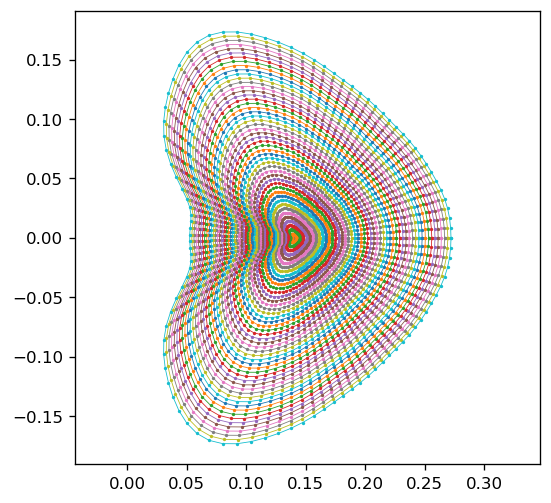

In [29]:
rgrid = xygrid[0]*am+R0M 
zgrid = xygrid[1]*am


plt.figure(figsize=(5,5), dpi=120)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(rgrid, zgrid, marker='.', linewidth=0.5, markersize = 2)
plt.show()

In [1]:
import plotly.graph_objects as go

fig = go.Figure(data = go.Surface(x = vtgrid[0,1:-1,1:-1], 
                                  y = vtgrid[1,1:-1,1:-1], 
                                  z = grady[1][1:-1,1:-1]))
fig.show()

NameError: name 'vtgrid' is not defined

In [23]:
#Psi = 0.001*np.random.rand(Nt,Np)
#Psi[:,-1]= 0.01
#Psi[:,0] = 0
P_profile = lambda r: .17/(0.011+(r-0.15)**2)**2
I_profile = lambda r: .15/(0.01+(r-0.15)**2)**2





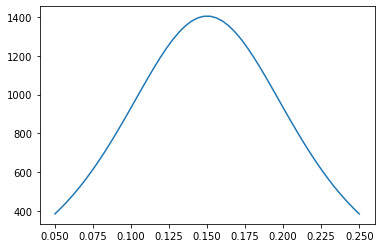

In [24]:
R = np.linspace(0.05, 0.25)

P = P_profile(R)
plt.plot(R, P)

In [6]:
from scipy.optimize import minimize

#toroidal current density
rminor = np.sum(Rmed)/len(Rmed)

print(rminor)

R, Z, J = np.loadtxt('PuntosJ.txt', skiprows = 1, delimiter=',').T

coefs = np.random.rand(10)

powerseries = lambda r, a: np.sum([a[i]*(r/rminor)**i for i in range(len(a))], axis=0)

def square_error(coefs, R, J):
    err = 1/len(R)*(J - powerseries(R, coefs))**2 
    return np.sum(err)

res = minimize(square_error, coefs ,args = (R, J), method='BFGS', tol=1e-4)



0.13509872897074793


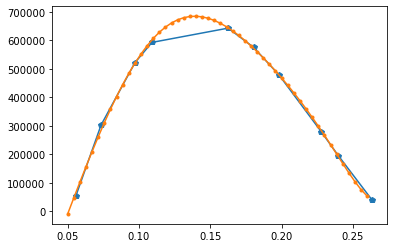

In [7]:
r = np.linspace(0.05, 0.26)
sol = powerseries(r, res.x)
plt.plot(R,J, marker='p')
plt.plot(r, sol, marker='.')


In [19]:
def derivatives(vtgrid, xygrid, am):
    _,a,b = vtgrid.shape
    dervs = np.zeros((a-2,b-2,2,2))
    dxdt, dxdv = np.gradient(xygrid[0,1:-1,1:-1], vtgrid[1,1:-1,0], vtgrid[0,0,1:-1])
    dydt, dydv = np.gradient(xygrid[1,1:-1,1:-1], vtgrid[1,1:-1,0], vtgrid[0,0,1:-1])
    for i in range(0,a-2):
        for j in  range(0,b-2): 
            dervs[i,j] = am*np.array([[dydt[i,j], dxdt[i,j]], 
                                   [dydv[i,j], dxdv[i,j]]])
            
    return dervs

a = derivatives(vtgrid, xygrid, am)

def magfield(Psi,vtgrid, xygrid, am):
    a, b = Psi.shape
    dervs = np.linalg.inv(derivatives(vtgrid, xygrid, am))
    dPsidt, dPsidv = np.array(np.gradient(Psi[1:-1,1:-1], 
                                vtgrid[1,1:-1,0], 
                                vtgrid[0,0,1:-1]))
    
    B = np.zeros((a-2,b-2,3))
    
    for i in range(0,a-2):
        for j in  range(0,b-2):
            dPsi = np.array([dPsidt[i,j], dPsidv[i,j]])
            dPsicil = dervs[i,j] @ dPsi
            B[i,j] = np.array([dPsicil[0], 2*np.pi*dPsicil[0], dPsicil[1]])
    
    return B
            
b = magfield(Psi, vtgrid, xygrid, am)


NameError: name 'vtgrid' is not defined

In [13]:
#definition of hermite polynomials

H00 = lambda x, y, x0, y0: (1/16)*(x+x0)**2*(x*x0-2)*(y+y0)**2*(y*y0-2)
H10 = lambda x, y, x0, y0: -x0*(1/16)*(x+x0)**2*(x*x0-1)*(y+y0)**2*(y*y0-2)
H01 = lambda x, y, x0, y0: -(1/16)*(x+x0)**2*(x*x0-2)*(y+y0)**2*(y*y0-1)
H11 = lambda x, y, x0, y0: x0*(1/16)*(x+x0)**2*(x*x0-1)*(y+y0)**2*(y*y0-1)

In [28]:
xquads = np.zeros((tp-1, n_p-1,4))
yquads = np.zeros((tp-1, n_p-1,4))

M = np.array([[1,-1,-1,1],
             [1, 1,-1,-1],
             [1, 1, 1, 1],
             [1,-1,1 ,-1]])
aquads = np.zeros(xquads.shape)
bquads = np.zeros(yquads.shape)
Minv = np.linalg.inv(M)

for i in range(tp-1):
    for j in range(n_p-1):
        xquads[i,j] = [xgrid[i,j],xgrid[i,j+1], xgrid[i+1,j+1],xgrid[i+1,j]]
        yquads[i,j] = [ygrid[i,j],ygrid[i,j+1], ygrid[i+1,j+1],ygrid[i+1,j]]
        aquads[i,j] = Minv @ xquads[i,j]
        bquads[i,j] = Minv @ yquads[i,j]

NameError: name 'tp' is not defined

In [ ]:
gamma = lambda st: Minv.T @ st#phi basis functions
F = lambda ab, st: ab @ st #coords transform
jac = lambda a,b, st: np.array([[a[1]+a[3]*st[2], a[2]+a[3]*st[1]],
                              [b[1]+b[3]*st[2], b[2]+b[3]*st[1]]]) #jacobian
gradgamma = lambda dst: Minv.T @ dst 